# Introduction

In some cases I have tested, nearly 80% of panorama are overlapping areas. For example, when we suppose there are 25% of overlapping area between two adjacent images, as it overlaps in top, bottom, left, and right, half of the image is overlapped. When 30%, 72.5% of image are overlapped. It would be larger when we warp images.

Therefore, no matter how perfect stitching algorithms we use - feature detection, matching, warping, ghosting(overlaping of same objects) is inevitable, because image pieces have so many overlapping areas for matching. 

The easy way to avoid it is seam finding.

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [3]:
folder = '../images/recent-04/'

img1 = cv.imread(folder + 'img-r1-095.jpg')
img2 = cv.imread(folder + 'img-r1-118.jpg')
h, w, _ = img1.shape

# DpSeamFinder

I have tested several seam finders provided by OpenCV:
* cv.detail.SeamFinder_createDefault(cv.detail.SeamFinder_VORONOI_SEAM)
* cv.detail_GraphCutSeamFinder("COST_COLOR")
* cv.detail_GraphCutSeamFinder("COST_COLOR_GRAD")
* cv.detail_DpSeamFinder("COLOR")

They all didn't work. The only one finder which works well for me was `cv.detail_DpSeamFinder("COLOR_GRAD")`.

In [3]:
seam_finder = cv.detail_DpSeamFinder("COLOR_GRAD")

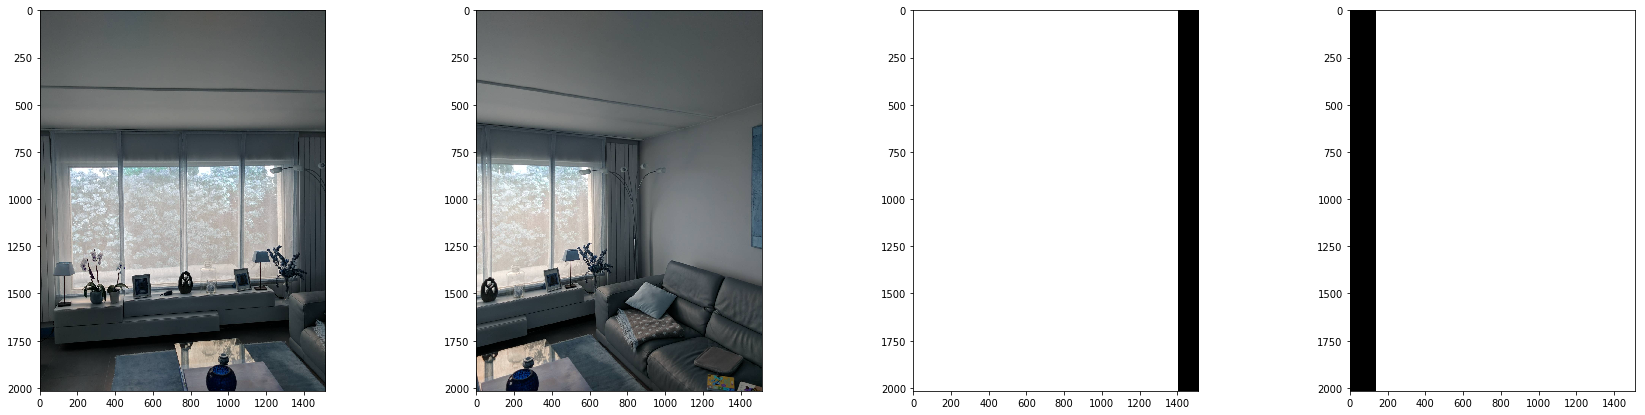

In [4]:
mask1 = np.ones((h, w), np.uint8) * 255
mask1[:, 1400:] = 0
mask2 = np.ones((h, w), np.uint8) * 255
mask2[:, :137] = 0

_, ax = plt.subplots(1, 4, figsize=(30, 7))
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[2].imshow(mask1, cmap='gray')
ax[3].imshow(mask2, cmap='gray')
plt.show()

In [5]:
mat1, mat2 = seam_finder.find([img1.astype(np.float32), img2.astype(np.float32)],
                [(0, 0), (760, 0)],
                [mask1, mask2])

In [6]:
mat1.get()

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

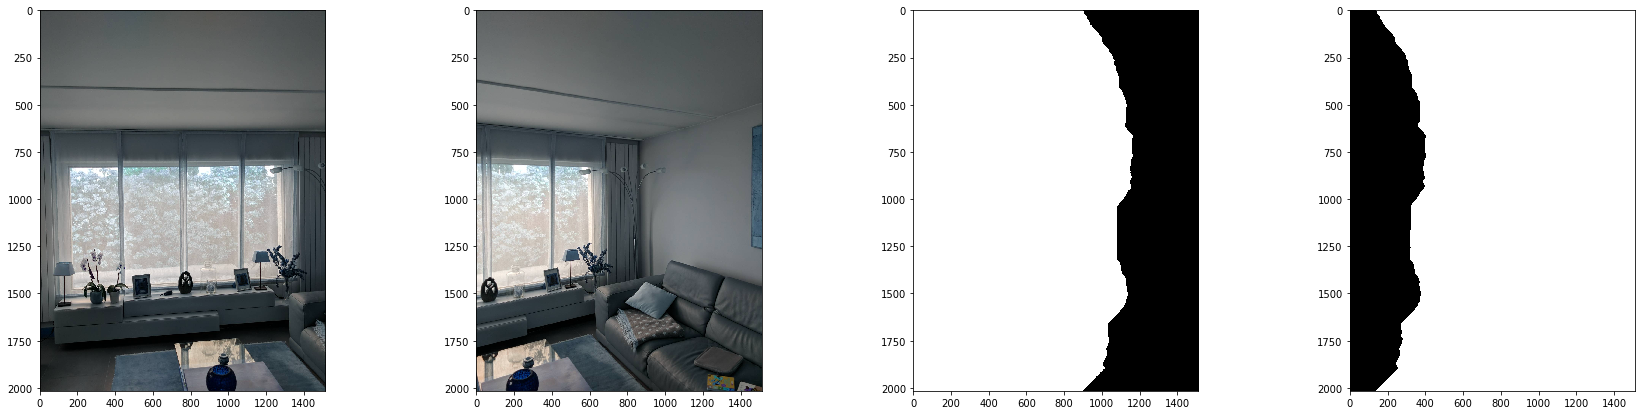

In [7]:
_, ax = plt.subplots(1, 4, figsize=(30, 7))
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[2].imshow(mat1.get(), cmap='gray')
ax[3].imshow(mat2.get(), cmap='gray')
plt.show()

### Seam was found, now let's blend it.

In [4]:
h, w, _ = img1.shape

blender = cv.detail_MultiBandBlender()

dst_sz = cv.detail.resultRoi(corners=[(0, 0), (760, 0)],
                             sizes=[(w, h), (w, h)])
blend_width = np.sqrt(dst_sz[2]*dst_sz[3]) / 100
blender.setNumBands((np.log(blend_width)/np.log(2.) - 1.).astype(np.int))
blender.prepare(dst_sz)

In [9]:
blender.feed(cv.UMat(img1), mat1.get(), (0, 0))
blender.feed(cv.UMat(img2), mat2.get(), (760, 0))

In [10]:
result,result_mask = blender.blend(None, None)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


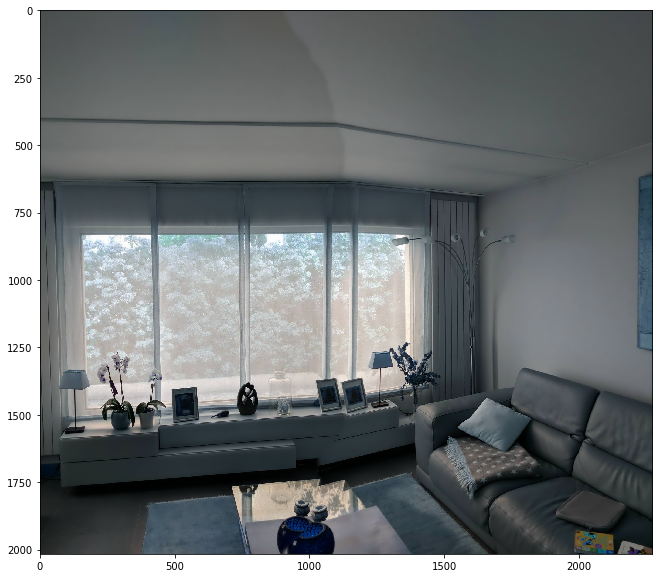

In [11]:
plt.figure(figsize=(15, 10))
plt.imshow(result)
plt.show()

#### Good! But the seam is still noticable. I think it's blender's fault and I will furthur test on blenders.

# Speed of Seam Finder

When I applied this seam finder on my stitching pipeline, it was frozen stuck in the seam finding process for so long and at last the process was killed. It seems that the seam finder consumes abundant CPU and RAM resources, and furthermore, I couldn't find a way to make the seam finder works in multi processors.

So, I have to shrink images pieces for seam finding and then dilate them for blending.

In [17]:
# size of the original image
h * w

3048192

It's 3 MPixel. Let's suppose we will work on 0.01MPixel

In [18]:
seam_scale = min(1.0, np.sqrt(1e4 / (h * w)))
seam_scale

0.057276812419605735

In [19]:
# original values
folder = '../images/recent-04/'

img1 = cv.imread(folder + 'img-r1-095.jpg')
img2 = cv.imread(folder + 'img-r1-118.jpg')

mask1 = np.ones((h, w), np.uint8) * 255
mask1[:, 1400:] = 0
mask2 = np.ones((h, w), np.uint8) * 255
mask2[:, :137] = 0

corners = [(0, 0), (760, 0)]

In [21]:
# seam values
seam_images = []
seam_images.append(cv.resize(img1, dsize=None, fx=seam_scale, fy=seam_scale, interpolation=cv.INTER_LINEAR_EXACT))
seam_images.append(cv.resize(img2, dsize=None, fx=seam_scale, fy=seam_scale, interpolation=cv.INTER_LINEAR_EXACT))

seam_masks = []
seam_masks.append(cv.resize(mask1, dsize=None, fx=seam_scale, fy=seam_scale, interpolation=cv.INTER_LINEAR_EXACT))
seam_masks.append(cv.resize(mask2, dsize=None, fx=seam_scale, fy=seam_scale, interpolation=cv.INTER_LINEAR_EXACT))

seam_corners = []
for corner in corners:
    seam_corners.append((int(corner[0] * seam_scale), int(corner[1] * seam_scale)))
seam_corners

[(0, 0), (43, 0)]

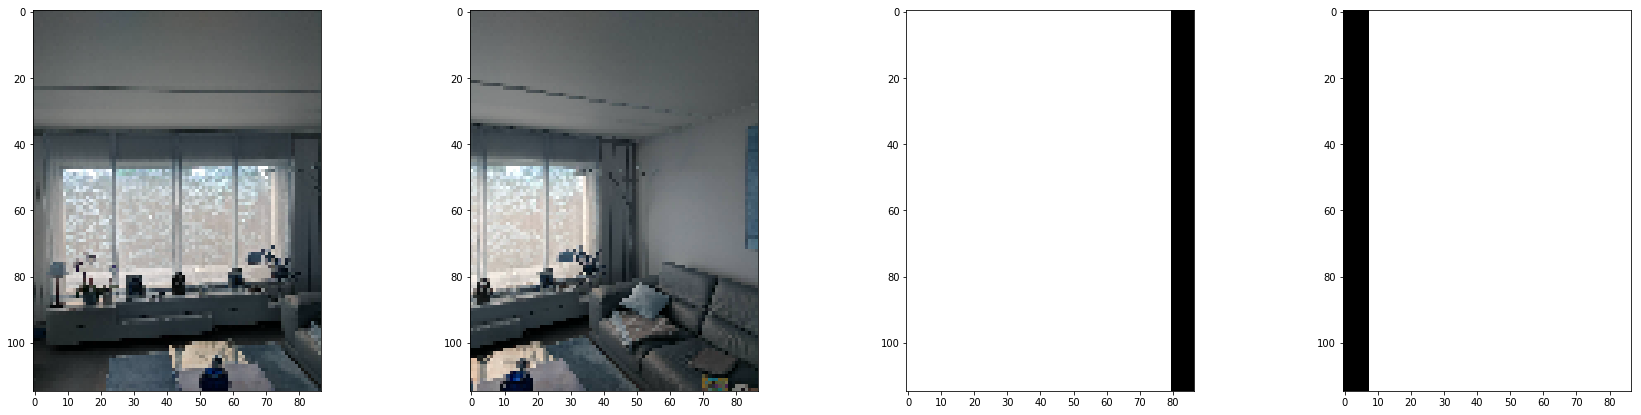

In [22]:
_, ax = plt.subplots(1, 4, figsize=(30, 7))
ax[0].imshow(seam_images[0])
ax[1].imshow(seam_images[1])
ax[2].imshow(seam_masks[0], cmap='gray')
ax[3].imshow(seam_masks[1], cmap='gray')
plt.show()

In [23]:
for idx in range(len(seam_images)):
    seam_images[idx] = seam_images[idx].astype(np.float32)
    print(type(seam_images[idx]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [24]:
seam_finder = cv.detail_DpSeamFinder("COLOR_GRAD")
mat1, mat2 = seam_finder.find(seam_images, seam_corners, seam_masks)

### Now, blend them in their original size

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


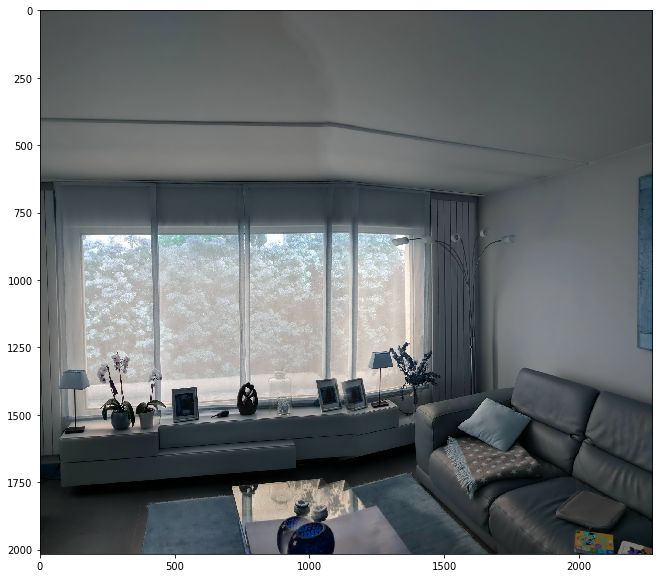

In [25]:
blender = cv.detail_MultiBandBlender()

dst_sz = cv.detail.resultRoi(corners=[(0, 0), (760, 0)],
                             sizes=[(w, h), (w, h)])
blend_width = np.sqrt(dst_sz[2]*dst_sz[3]) / 100
blender.setNumBands((np.log(blend_width)/np.log(2.) - 1.).astype(np.int))
blender.prepare(dst_sz)

seam_mask1 = cv.dilate(mat1.get(),None)
seam_mask1 = cv.resize(seam_mask1,(mask1.shape[1], mask1.shape[0]), 0, 0, cv.INTER_LINEAR_EXACT)
mask_final1 = cv.bitwise_and(seam_mask1, mask1)

seam_mask2 = cv.dilate(mat2.get(),None)
seam_mask2 = cv.resize(seam_mask2,(mask2.shape[1], mask2.shape[0]), 0, 0, cv.INTER_LINEAR_EXACT)
mask_final2 = cv.bitwise_and(seam_mask2, mask2)

blender.feed(cv.UMat(img1), mask_final1, (0, 0))
blender.feed(cv.UMat(img2), mask_final2, (760, 0))

result,result_mask = blender.blend(None, None)

plt.figure(figsize=(15, 10))
plt.imshow(result)
plt.show()

## OK! We have found seams on 1/20 reduced image and it worked well.